# Style Transfer Model

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Image loader: removes need to crop images


In [3]:
def load_img(path):
    max_dim = 512
    img = Image.open(path)
    if img.size[1] > img.size[0]:
        img = img.rotate(90, expand=True)
#     print(img.size)
    scale = max_dim / max(img.size)
    new_shape = int(scale * img.size[1]), int(scale * img.size[0])
    tsfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(new_shape)
    ])
    
    img = tsfm(img)
    
    return img.unsqueeze(0).to(device)

## Function to show images after style has been transfered

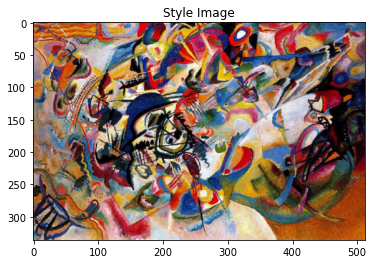

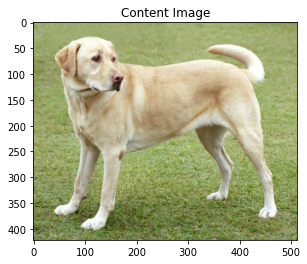

torch.Size([1, 3, 336, 512]) torch.Size([1, 3, 422, 512])


In [4]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()
style_img = load_img("./images/comp.jpg")
content_img = load_img("./images/lab.jpg")
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated



plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

print(style_img.shape, content_img.shape)

## Building models for style transfer

In [5]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
#         print("C", input.shape, self.target.shape)
        self.loss = F.mse_loss(input, self.target)
        return input

### Adjusted Gram Matrix to allow different image widths

In [6]:
def gram_matrix(input_tensor):
    result =  torch.einsum('bcji,bdji->bcd', input_tensor, input_tensor)
    input_shape = input_tensor.shape
    num_locations = (input_shape[1]*input_shape[2])
    
    return result/num_locations


In [7]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        
#         print("S", G.shape, self.target.shape)
        
        self.loss = F.mse_loss(G, self.target)
        return input

## Pretrained VGG19 model used for feature finding

In [8]:
cnn = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

In [9]:
from torchsummary import summary
summary(cnn, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─ReLU: 1-2                              [-1, 64, 32, 32]          --
├─Conv2d: 1-3                            [-1, 64, 32, 32]          36,928
├─ReLU: 1-4                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-5                         [-1, 64, 16, 16]          --
├─Conv2d: 1-6                            [-1, 128, 16, 16]         73,856
├─ReLU: 1-7                              [-1, 128, 16, 16]         --
├─Conv2d: 1-8                            [-1, 128, 16, 16]         147,584
├─ReLU: 1-9                              [-1, 128, 16, 16]         --
├─MaxPool2d: 1-10                        [-1, 128, 8, 8]           --
├─Conv2d: 1-11                           [-1, 256, 8, 8]           295,168
├─ReLU: 1-12                             [-1, 256, 8, 8]           --
├─Conv2d: 1-13                           [-1, 256, 8, 8]        

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─ReLU: 1-2                              [-1, 64, 32, 32]          --
├─Conv2d: 1-3                            [-1, 64, 32, 32]          36,928
├─ReLU: 1-4                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-5                         [-1, 64, 16, 16]          --
├─Conv2d: 1-6                            [-1, 128, 16, 16]         73,856
├─ReLU: 1-7                              [-1, 128, 16, 16]         --
├─Conv2d: 1-8                            [-1, 128, 16, 16]         147,584
├─ReLU: 1-9                              [-1, 128, 16, 16]         --
├─MaxPool2d: 1-10                        [-1, 128, 8, 8]           --
├─Conv2d: 1-11                           [-1, 256, 8, 8]           295,168
├─ReLU: 1-12                             [-1, 256, 8, 8]           --
├─Conv2d: 1-13                           [-1, 256, 8, 8]        

In [10]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

## Creating Style and Content Networks from specific layers in VGG19

In [11]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_14']
style_layers_default = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)
        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [12]:
model, s, _ = get_style_model_and_losses(cnn, cnn_normalization_mean, cnn_normalization_std,
                               style_img, content_img)

## Training 

In [13]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [14]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


In [15]:
   
c_loss = []
s_loss = []
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1, content_weight=1):
    
    """Run the style transfer."""
    print('Building the style transfer model..')
    start = time.time() 
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    
    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)
    print(style_losses[0].loss)
    print('Optimizing..')
    run = [0]
    out_imgs = []
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
                
            for cl in content_losses:
                content_score += cl.loss

#             print(style_score)

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
#             print(loss)
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                s_loss.append(sl.loss)
                c_loss.append(cl.loss)
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print('%s (%d %d%%)' % (timeSince(start, run[0] / num_steps),
                                         run[0], run[0] / num_steps * 100))
                print()
                
            if run[0] % (num_steps/4) == 0:
#                 print(run[0])
                res = input_img.clone().detach()
                out_imgs.append(res)

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return out_imgs


In [16]:
input_img = content_img.clone()

## Function to display the 4 outputs as the image changes over time

In [17]:
def displayOuts(outputs):

    fig = plt.figure(figsize=(16,16))

    for i in range(4):
        ax1 = fig.add_subplot(2,2,i+1)
        ax1.set_title(i)
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.imshow(unloader(outputs[i].cpu().squeeze(0)))



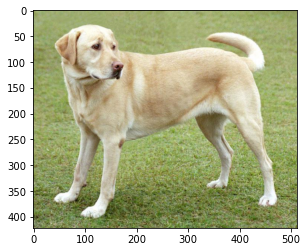

Building the style transfer model..
tensor(22.2483, device='cuda:0', grad_fn=<MseLossBackward0>)
Optimizing..
run [50]:
Style Loss : 15.374541 Content Loss: 4.240072
0m 6s (- 0m 30s) (50 16%)

run [100]:
Style Loss : 6.925748 Content Loss: 2.778795
0m 12s (- 0m 25s) (100 33%)

run [150]:
Style Loss : 4.059867 Content Loss: 2.215143
0m 20s (- 0m 20s) (150 50%)

run [200]:
Style Loss : 2.619222 Content Loss: 1.875569
0m 27s (- 0m 13s) (200 66%)

run [250]:
Style Loss : 1.813843 Content Loss: 1.624355
0m 34s (- 0m 6s) (250 83%)

run [300]:
Style Loss : 1.465874 Content Loss: 1.443726
0m 42s (- 0m 0s) (300 100%)



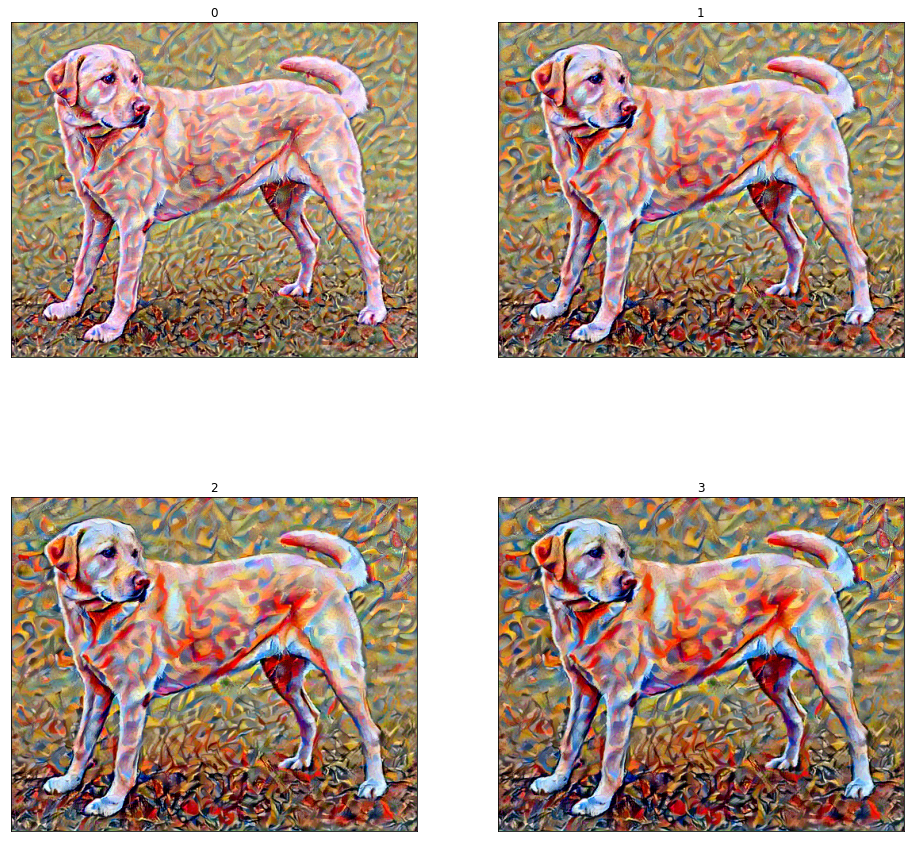

In [18]:
imshow(input_img)
outputs = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=300)
displayOuts(outputs)


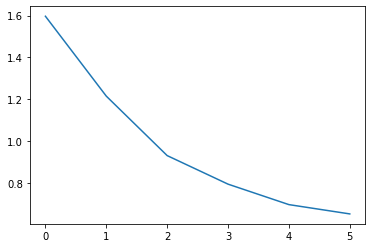

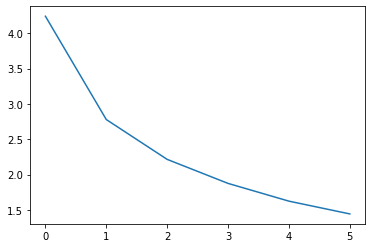

In [19]:
sls = []
cls = []

for i in s_loss:
    sls.append(i.item())
for i in c_loss:
    cls.append(i.item())
plt.plot(sls)
plt.show()

plt.plot(cls)
plt.show()

## Using the model on different data

In [20]:
style_img = load_img("./images/shapes.jfif")
content_img = load_img("./images/car.jpg")
input_img = content_img.clone()

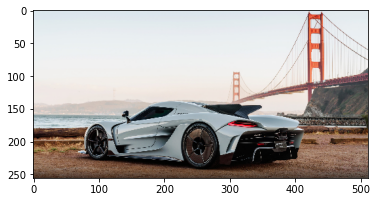

Building the style transfer model..
tensor(34.4458, device='cuda:0')
Optimizing..
run [50]:
Style Loss : 38.557667 Content Loss: 3.762544
0m 3s (- 0m 18s) (50 16%)

run [100]:
Style Loss : 20.855896 Content Loss: 3.092786
0m 8s (- 0m 16s) (100 33%)

run [150]:
Style Loss : 11.650640 Content Loss: 2.719997
0m 12s (- 0m 12s) (150 50%)

run [200]:
Style Loss : 6.787312 Content Loss: 2.380794
0m 17s (- 0m 8s) (200 66%)

run [250]:
Style Loss : 4.547760 Content Loss: 2.208447
0m 22s (- 0m 4s) (250 83%)

run [300]:
Style Loss : 3.553260 Content Loss: 2.057459
0m 27s (- 0m 0s) (300 100%)



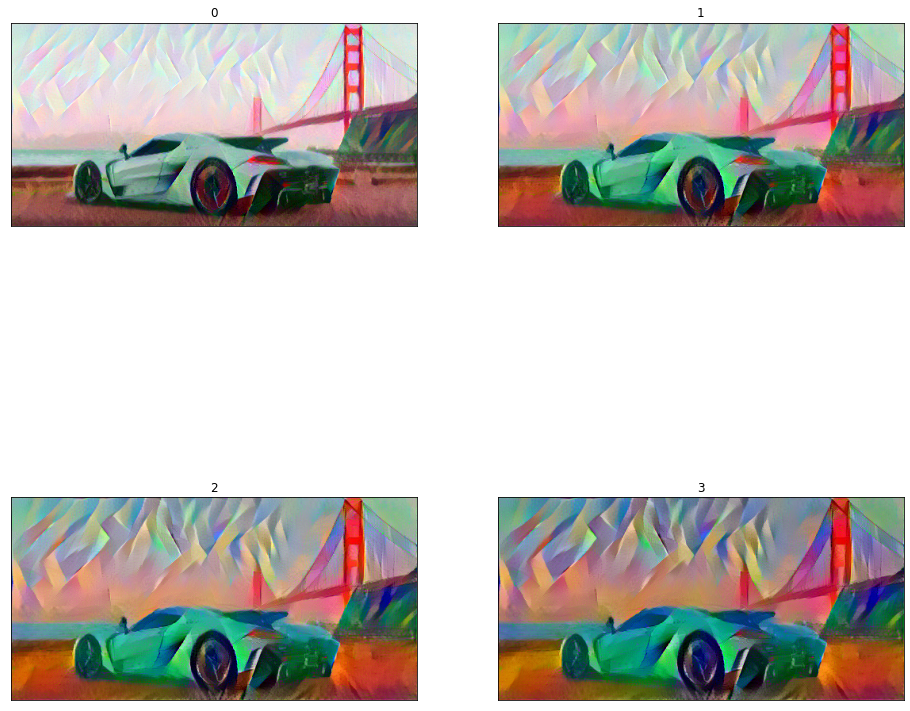

In [21]:
imshow(input_img)
outputs = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=300)
displayOuts(outputs)

## Choosing the best Image

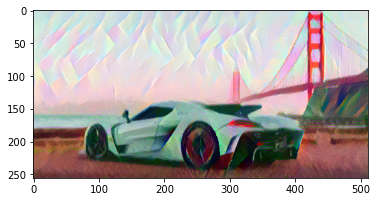

In [22]:
imshow(outputs[0])